In [6]:
!pip3 install pygame --user

  Using cached https://files.pythonhosted.org/packages/18/b3/0bf5afdcf6ef95d2a343cd7865585a6efe5e3e727c1a4f3385c9935248cf/pygame-1.9.6-cp37-cp37m-manylinux1_x86_64.whl


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import deque
from SnakeEnv import SnakeEnvironment

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class Net(nn.Module):

    def __init__(self, learning_rate=0.01):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_size, 12)  
        self.fc2 = nn.Linear(12, 24)
        self.fc3 = nn.Linear(24, action_size)
        self.optim  = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.loss = torch.nn.MSELoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, x):
        #print(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        #print(x[0][0].item())
        return x


In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.max_memory = 2000 
        self.state_memory = np.zeros((self.max_memory,self.state_size))
        self.action_memory = np.zeros((self.max_memory,1))
        self.reward_memory = np.zeros((self.max_memory,1))
        self.next_state_memory = np.zeros((self.max_memory,self.state_size))
        self.done_memory = np.zeros((self.max_memory,1))
        self.memory_size = 0 #current size of memory
        self.dueling_type = 'avg'
        self.loss = []

        # Hyperparameters
        self.gamma = 0.99    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9998
        self.learning_rate = 0.001
        self.DQN = Net(self.learning_rate)
        self.target_network = Net(self.learning_rate)
        self.target_network.load_state_dict(self.DQN.state_dict())

    def remember(self, state, action, reward, next_state, done):
        index = self.memory_size%self.max_memory
        if self.memory_size < self.max_memory:
            self.state_memory[self.memory_size] = state
            self.action_memory[self.memory_size] = action
            self.reward_memory[self.memory_size] = reward
            self.next_state_memory[self.memory_size] = next_state
            self.done_memory[self.memory_size] = done
            self.memory_size += 1
        else:
            self.state_memory[index] = state
            self.action_memory[index] = action
            self.reward_memory[index] = reward
            self.next_state_memory[index] = next_state
            self.done_memory[index] = done


    def act(self, state):
        #np.random.seed(0)
        #torch.manual_seed(0)
        #random.seed(30)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.DQN.forward(torch.tensor(state,dtype=torch.float32).to(self.DQN.device))
        action = torch.argmax(act_values).item() 
        #print(act_values)
        return action # returns action

    def replay(self, batch_size):
        self.DQN.optim.zero_grad()

        batch = np.random.choice(self.memory_size,batch_size)
            
        state_batch = torch.tensor(self.state_memory[batch],device = self.DQN.device,dtype=torch.float32)
        action_batch = torch.tensor(self.action_memory[batch],device = self.DQN.device, dtype=torch.uint8)
        reward_batch = torch.tensor(self.reward_memory[batch],device = self.DQN.device,dtype=torch.float32)
        next_state_batch = torch.tensor(self.next_state_memory[batch],device = self.DQN.device,dtype=torch.float32)
        done_batch = torch.tensor(self.done_memory[batch],device = self.DQN.device,dtype=torch.uint8)

        Q_value = self.DQN.forward(state_batch).to(self.DQN.device)
        Q_target = Q_value.clone()
        Q_next = self.target_network.forward(next_state_batch).to(self.DQN.device)
        batch_index = np.arange(batch_size,dtype=np.int32)
        #print(Q_value)

        idx = np.array(list(zip(batch_index,action_batch.cpu().numpy().reshape(-1))))
        Q_target[idx[:, 0], idx[:, 1]] = reward_batch.float().reshape(-1) + \
        self.gamma * torch.max(Q_next, dim=1)[0] * (1-done_batch.float().reshape(-1))
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        loss = self.DQN.loss(Q_target, Q_value).to(self.DQN.device)
        loss.backward()
   
        self.loss.append(loss.item())
        self.DQN.optim.step()


    def load(self, PATH):
        self.DQN.load_state_dict(torch.load(PATH))
        self.DQN.eval()
        
    def clear_loss(self):
        self.loss = []
        

    def save(self, PATH):
        torch.save(self.DQN.state_dict(), PATH)

    #Fixed Q targets
    def update_target_weights(self):
        self.target_network.load_state_dict(self.DQN.state_dict())


In [4]:
EPISODES = 10000
DURATION = 500
SS = 30
tau = 100

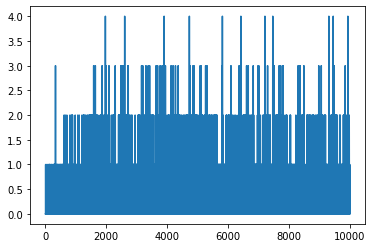

In [5]:
render = False
env = SnakeEnvironment(screenSize = SS,render = render)
state_size = len(env.state)
action_size = len(env.actions)
memory = deque(maxlen=2000)
agent = DQNAgent(state_size, action_size)
agent.load("snake-v4-dqn.pt")
batch_size = 30
scores = []
apples = []
losses = []
for e in range(EPISODES):
    env = SnakeEnvironment(screenSize = SS, render=render)
    state = env.state
    state = np.reshape(state, [1, state_size])
    apples_collected = 0
    for time in range(DURATION+1):
        action = agent.act(state)
        next_state, reward, done, apple = env.step(action)
        apples_collected += apple
        next_state = np.reshape(next_state, [1, state_size])
        if time == DURATION:
            reward += 10
        if reward != 0:
            agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done or time == DURATION:

            if e % (EPISODES/10) == 0:
                pass
                #print("episode: {}/{}, score: {}, e: {:.2}".format(e, EPISODES, apples_collected, agent.epsilon))
            scores.append(env.totalReward)
            apples.append(apples_collected)
            losses.append(agent.loss)
            break
        if time % tau == 0:
            agent.update_target_weights()


            if agent.memory_size > batch_size:
                agent.replay(batch_size)

    if e % 10 == 0:
        agent.save("snake-v4-dqn.pt")

avg_loss = np.array(losses).mean(axis=0)
plt.plot(range(len(apples)),apples)
plt.show()

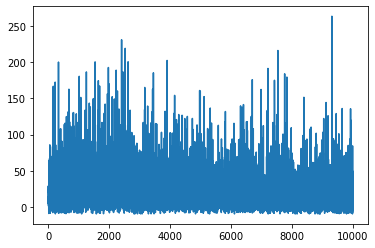

In [6]:
plt.plot(range(len(scores)),scores)
plt.show()

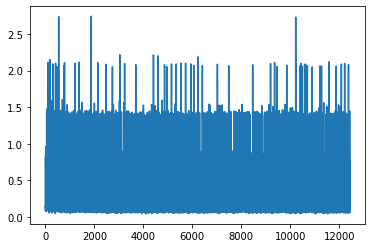

In [7]:
plt.plot(range(len(avg_loss)),avg_loss)
plt.show()